# Assessing results

## Environment setup

In [5]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"NumPy version: {np.__version__}")

Python version: 3.7.5
NumPy version: 1.18.1


In [6]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [7]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.22"  # For plotting API

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    plot_confusion_matrix,
    classification_report,
    plot_roc_curve,
)
from sklearn.model_selection import cross_val_score

scikit-learn version: 0.22.1


In [8]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)

TensorFlow version: 2.3.1
Keras version: 2.4.0


## Problem formulation

### Model

The representation learnt from data during training is called a **model**. It defines the relationship between inputs and outputs, and thus produces results from data. Most (but not all) ML systems are model-based.

[![Extract from the book Hands-on Machine Learning with Scikit-Learn & TensorFlow by A. Géron](images/instance_model_learning.png)](https://github.com/ageron/handson-ml2)

### Model parameters and hypothesis function

- $\pmb{\theta}$ (sometime noted $\pmb{\omega}$): set of model's internal parameters, updated during training.
- $h_\theta()$: model's prediction function (*hypothesis function*), using the model parameters $\pmb{\theta}$ to define the relationship between features and labels.
- $y'^{(i)}$ (sometimes noted $\hat{y}^{(i)}$): hypothesis function output (model prediction).

$$y'^{(i)} = h_\theta(\pmb{x}^{(i)})$$ 

### Loss

- $\mathcal{L_{\pmb{X, y}}(\pmb{\theta})}$, sometimes noted $\mathcal{J_{\pmb{X, y}}(\pmb{\theta})}$: **loss function** that quantifies the difference, often called **error**, between expected results (called *ground truth*) and actual results computed by the model.
- Also called **cost** or **objective function**.
- During model training, the input dataset $\pmb{X}$ and the expected results $\pmb{y}$ can be treated as constants. The loss depends solely on the model parameters $\pmb{\theta}$. To simplify notations, the loss function will be written $\mathcal{L(\pmb{\theta})}$.

## Common losses

### Regression losses

#### Mean Absolute Error

Aka *L1 norm*.

$$\mathrm{MAE}(\boldsymbol{\pmb{\theta}}) = \frac{1}{m}\sum_{i=1}^m |\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)}| = \frac{1}{m}{\lVert{h_\theta(\pmb{X}) - \pmb{y}}\rVert}_1$$

#### Mean Squared Error

Aka *squared L2 norm*. Most sensible to outliers.

$$\mathrm{MSE}(\boldsymbol{\pmb{\theta}}) = \frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)})^2 = \frac{1}{m}{{\lVert{h_\theta(\pmb{X}) - \pmb{y}}\rVert}_2}^2$$

#### Root Mean Squared Error

The default choice in many contexts.

$$\mathrm{RMSE}(\boldsymbol{\pmb{\theta}}) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)})^2}$$

In [9]:
# Expected and actual results
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

mae = mean_absolute_error(y_true, y_pred)
assert mae == (0.5 + 0.5 + 0 + 1) / 4
print(mae)

mse = mean_squared_error(y_true, y_pred)
assert mse == (0.5**2 + 0.5**2 + 0**2 + 1**2) / 4
print(mse)

rmse = np.sqrt(mse)
print(rmse)

0.5
0.375
0.6123724356957945


### Classification losses

#### Binary classification

- $y^{(i)} \in \{0,1\}$: expected result for the $i$th data sample.
- $y'^{(i)} \in [0,1]$: model output for the $i$th data sample.

(loss:bce)=

##### Binary crossentropy

$$\mathrm{BCE}(\boldsymbol{\pmb{\theta}}) = -\frac{1}{m}\sum_{i=1}^m \left(y^{(i)} \log_e(y'^{(i)}) + (1-y^{(i)}) \log_e(1-y'^{(i)})\right)$$

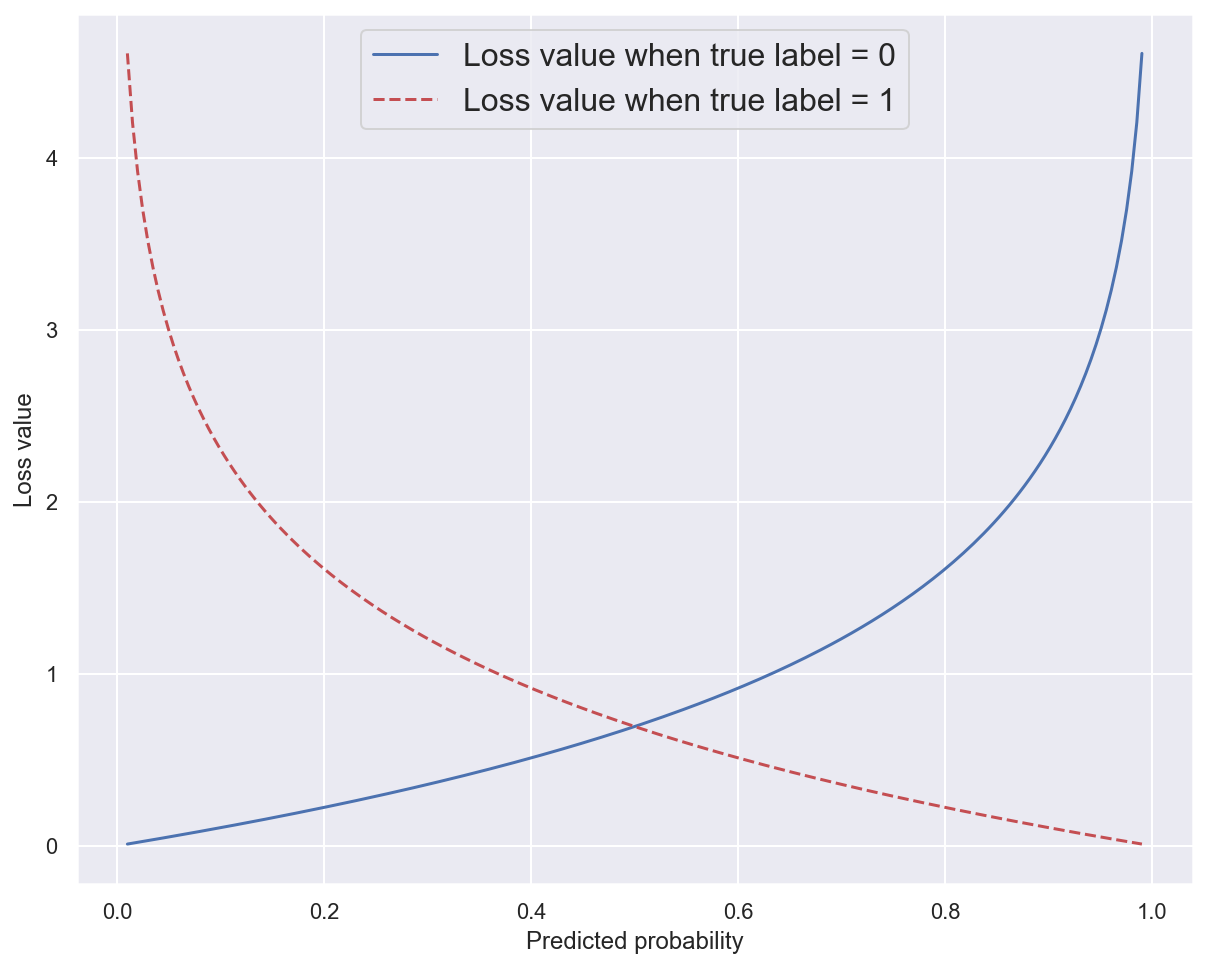

In [17]:
# Plot -log(x) for x in ]0,1[
x = np.linspace(0.01, 0.99, 200)
plt.plot(x, -np.log(1 - x), label="Loss value when true label = 0")
plt.plot(x, -np.log(x), "r--", label="Loss value when true label = 1")
plt.xlabel("Predicted probability")
plt.ylabel("Loss value")
plt.legend(fontsize=16)
plt.show()

In [7]:
y_true = [0, 0, 1, 1]
bce_fn = BinaryCrossentropy()

y_pred = [0.1, 0.2, 0.7, 0.99]
bce = bce_fn(y_true, y_pred)
print(f"BCE (good prediction): {bce}")
# Compare expected and computed values
np.testing.assert_almost_equal(
    -(np.log(0.9) + np.log(0.8) + np.log(0.7) + np.log(0.99)) / 4, bce
)

# Perfect prediction
y_pred = [0., 0., 1., 1.]
print(f"BCE (perfect prediction): {bce_fn(y_true, y_pred)}")

# Awful prediction
y_pred = [0.9, 0.85, 0.17, 0.05]
print(f"BCE (awful prediction): {bce_fn(y_true, y_pred)}")

BCE (good prediction): 0.17380718886852264
BCE (perfect prediction): 0.0
BCE (awful prediction): 2.241847515106201


#### Multiclass classification

* $K$: number of classes.
* $\pmb{y}^{(i)}$ (the *ground truth* for the *i*th data sample) can either be:
  - a **discrete integer value** equal to $k \in \{0, K-1\}$, the sample's class;
  - a **binary vector** of $K$ values, typically obtained by **one-hot encoding** the targets. In that case, $y^{(i)}_k$ is equal to 1 if the $i$th sample belongs to class $k$, 0 otherwise.
* $\pmb{y}'^{(i)}$ is a vector of $K$ values, computed by the model. It can either be:
  - a **score vector** of raw decimal values, also called a **logit vector**;
  - a **probability distribution vector**: in that case, $y'^{(i)}_k$ represents the probability that the $i$th sample belongs to class $k$.

$$\pmb{y}'^{(i)} = \begin{pmatrix}
       \ y'^{(i)}_1 \\
       \ y'^{(i)}_2 \\
       \ \vdots \\
       \ y'^{(i)}_K
     \end{pmatrix} \in \pmb{R}^K
\;\;\;
\pmb{Y}' = \begin{bmatrix}
       \ \pmb{y}'^{(1)T} \\
       \ \pmb{y}'^{(2)T} \\
       \ \vdots \\
       \ \pmb{y}'^{(m)T} \\
     \end{bmatrix} =
\begin{bmatrix}
       \ y'^{(1)}_1 & \cdots & y'^{(1)}_K \\
       \ y'^{(2)}_1 & \cdots & y'^{(2)}_K \\
       \ \vdots & \ddots & \vdots \\
       \ y'^{(m)}_1 & \cdots & y'^{(m)}_K
     \end{bmatrix} \in \pmb{R}^{m \times K}$$

(loss:cce)=

##### Categorical Crossentropy

- Aka *log(istic) loss*.
- Expects one-hot encoded targets (binary vectors).
- Equivalent to Binary Crossentropy when $K = 2$.

$$\pmb{y}^{(i)} = \begin{pmatrix}
       \ y^{(i)}_1 \\
       \ y^{(i)}_2 \\
       \ \vdots \\
       \ y^{(i)}_K
     \end{pmatrix} \in \pmb{R}^K
\;\;\;
\mathcal{L}_{log}(\boldsymbol{\pmb{\theta}}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y^{(i)}_k \log_e(y'^{(i)}_k)$$

In [8]:
# 3 possibles classes. Sample 1 has class 2. Sample 2 has class 3
y_true = [[0, 1, 0], [0, 0, 1]]

# Probability distribution vector
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
cce_fn = CategoricalCrossentropy()
cce = cce_fn(y_true, y_pred).numpy()
print(cce)
# Compare theorical and computed loss values
np.testing.assert_almost_equal(
    -(np.log(0.95) + np.log(0.1)) / 2, cce
)

# Logit vector (for a different prediction)
y_pred = [[0.3, 0.9, -0.1], [0.27, 0.1, 0.78]]
cce_fn = CategoricalCrossentropy(from_logits=True)
cce_logits = cce_fn(y_true, y_pred).numpy()
print(cce_logits)

1.1769392
0.6979594


##### Sparse categorical crossentropy

Variation of Categorical Crossentropy that expects non-encoded, discrete integer targets.

In [9]:
# Same classes as before, this time expressed as integers
y_true = [1, 2]

# Probability distribution vector
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
scce_fn = SparseCategoricalCrossentropy()
scce = scce_fn(y_true, y_pred).numpy()
print(scce)
# Since classes and predictions are identical as before, loss values should be equal
assert scce == cce

# Logit vector (for a different prediction)
y_pred = [[0.3, 0.9, -0.1], [0.27, 0.1, 0.78]]
scce_fn = SparseCategoricalCrossentropy(from_logits=True)
scce_logits = scce_fn(y_true, y_pred).numpy()
print(scce_logits)
# Since classes and predictions are identical as before, loss values should be equal
assert scce_logits == cce_logits

1.1769392
0.6979594


## Model evaluation

### Using a validation set

In order to evaluate and tune model performance without involving the test dataset, training data is often split between a  training set and a smaller **validation set**.

![](images/dataset_splitting.png)

### Cross-validation

A more sophisticated validation strategy is to apply **K-fold cross validation**. Training data is randomly split into $K$ subsets called *folds*. The model is trained and evaluated $K$ times, using a different fold for validation.

![K-fold Cross Validation](images/k-fold-cross-validation.png)

## Performance metrics

(Heavily inspired by Chapter 3 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

### Regression metrics

A typical performance metric for regression tasks is the Root Mean Square Error.

$$ \mathrm{RMSE}(\mathbf{X}, h_\theta) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)})^2} $$

MAE (less sensitive to outliers) and MSE can also be used.

### Classification metrics

#### Context: recognizing handwritten digits

In [10]:
# Load the MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}. Test labels: {test_labels.shape}")

Training images: (60000, 28, 28). Training labels: (60000,)
Test images: (10000, 28, 28). Test labels: (10000,)


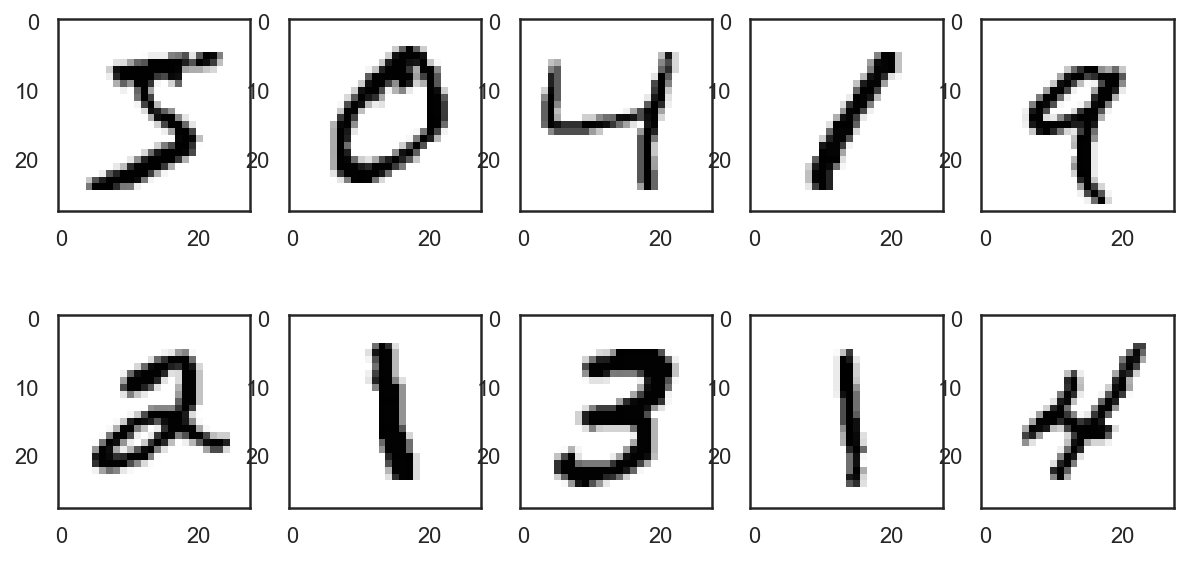

In [11]:
# Plot the first 10 digits
with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
    plt.figure(figsize=(10, 5))
    for i in range(10):
        digit = train_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit, cmap=plt.cm.binary)

In [12]:
# Reshape images into a (samples, 28x28) matrix
x_train = train_images.reshape((60000, 28 * 28))
x_test = test_images.reshape((10000, 28 * 28))

# 784=28x28
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

x_train: (60000, 784)
x_test: (10000, 784)


In [13]:
# Rescale pixel values from [0,255] to [0,1]

x_train = x_train / 255.0
# Alternative: x_train = x_train.astype("float32") / 255
x_test = x_test / 255.0
# Alternative: x_test = x_test.astype("float32") / 255

In [14]:
# Print the first 10 labels
print(train_labels[:10])

[5 0 4 1 9 2 1 3 1 4]


In [15]:
# Create binary vectors of expected results
# label is true for all 5s, false for all other digits
y_train_5 = train_labels == 5
y_test_5 = test_labels == 5

# true, false, false
print(y_train_5[0], y_train_5[1], y_train_5[2])

True False False


In [16]:
# Create a classifier using stochastic gradient descent and log loss
sgd_model = SGDClassifier(loss="log")

# Trains the model on data
sgd_model.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# Test on first 3 digits
samples = [x_train[0], x_train[1], x_train[2]]

# Print binary predictions (5/not 5)
print(sgd_model.predict(samples))

# Print prediction probabilities
sgd_model.predict_proba(samples).round(decimals=3)

[ True False False]


array([[0.163, 0.837],
       [0.999, 0.001],
       [1.   , 0.   ]])

#### Thresholding model output

The model outputs probabilities, or scores that are transformed into probabilities. These decimal values are thresholded into discrete values to form the model's prediction.

Thresholds are problem-dependent.

#### Accuracy

A simple evaluation metric for classification is **accuracy**.

$$Accuracy = \frac{\text{Number of exact predictions}}{\text{Total number of predictions}} $$

In [18]:
# Define ground truth and prediction vectors
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 1, 2, 2, 0, 1]

# Compute accuracy
acc = accuracy_score(y_true, y_pred)

print(f"Accuracy: {acc:.5f}")
assert acc == 4/6

Accuracy: 0.66667


In [19]:
# The score() method computes accuracy for SGDClassifier
train_acc = sgd_model.score(x_train, y_train_5)
print(f"Training accuracy: {train_acc:.05f}")

# Compare expected and computed values
assert train_acc == np.sum([sgd_model.predict(x_train) == y_train_5]) / len(x_train)

# Using cross-validation to evaluate accuracy, using 3 folds
cv_acc = cross_val_score(sgd_model, x_train, y_train_5, cv=3, scoring="accuracy")
print(f"CV accuracy: {cv_acc}")

Training accuracy: 0.97487
CV accuracy: [0.97085 0.9709  0.97165]


##### Accuracy shortcomings

When the dataset is *skewed* (some classes are more frequent than others), computing accuracy is not enough to assert the model's performance.

To find out why, let's imagine a dumb binary classifier that always predicts that the digit is not 5.

In [20]:
not5_count = (y_train_5 == False).sum()
print(f"There are {not5_count} digits other than 5 in the training set")

dumb_model_acc = not5_count / len(x_train)
print(f"Dumb classifier accuracy: {dumb_model_acc:.05f}")

There are 54579 digits other than 5 in the training set
Dumb classifier accuracy: 0.90965


#### True/False positives and negatives

- **True Positive (TP)**: the model _correctly_ predicts the positive class.
- **False Positive (FP)**: the model _incorrectly_ predicts the positive class.
- **True Negative (TN)**: the model _correctly_ predicts the negative class.
- **False Negative (FN)**: the model _incorrectly_ predicts the negative class.

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

#### Confusion matrix

Useful representation of classification results. Row are actual classes, columns are predicted classes.

[![Confusion matrix for 5s](images/confusion_matrix.png)](https://github.com/ageron/handson-ml2)

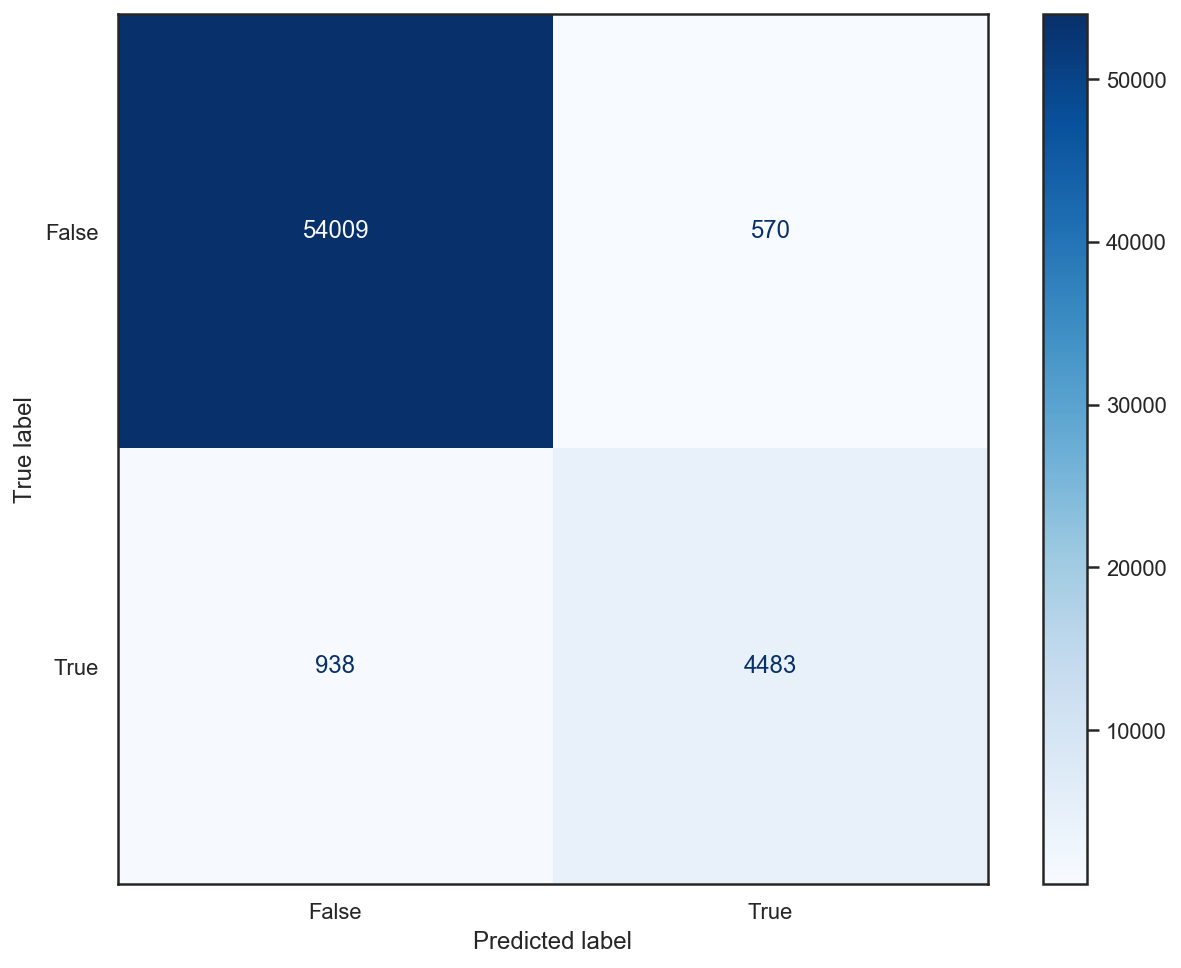

In [21]:
# Plot the confusion matrix for a model and a dataset
def plot_conf_mat(model, x, y):
    with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
        display = plot_confusion_matrix(
            model, x, y, values_format="d", cmap=plt.cm.Blues
        )


# Plot confusion matrix for the SGD classifier
plot_conf_mat(sgd_model, x_train, y_train_5)

#### Precision and recall

- **Precision**: proportion of positive identifications that were actually correct.
- **Recall** (or *sensitivity*): proportion of actual positives that were identified correctly.

$$Precision = \frac{TP}{TP + FP} = \frac{\text{True Positives}}{\text{Total Predicted Positives}}$$

$$Recall = \frac{TP}{TP + FN} = \frac{\text{True Positives}}{\text{Total Actual Positives}}$$

In [22]:
# Define ground truth and prediction vectors
y_true = [True, False, False, True, True, True]
y_pred = [True, True, False, True, False, False]

# Compute precision
precision = precision_score(y_true, y_pred, average=None)
print(f"Precision: {precision}")
# False class: 1 TP, 2 FP. True class: 2 TP, 1 FP
np.testing.assert_array_equal([1/3, 2/3], precision)

# Compute recall
recall = recall_score(y_true, y_pred, average=None)
print(f"Recall: {recall}")
# False class: 1 TP, 1 FN. True class: 2 TP, 2 TN
np.testing.assert_array_equal([1/2, 1/2], recall)

Precision: [0.33333333 0.66666667]
Recall: [0.5 0.5]


##### Example: a (flawed) tumor classifier

Context: binary classification of tumors (positive means malignant). Dataset of 100 tumors, of which 9 are malignant.

| Negatives | Positives |
|-|-|
| True Negatives: 90 | False Positives: 1 |
| False Negatives: 8 | True Positives: 1|

$$Accuracy = \frac{90+1}{100} = 91\%$$
$$Precision = \frac{1}{1 + 1} = 50\%\;\;\;
Recall = \frac{1}{1 + 8} = 11\%$$

##### The precision/recall trade-off

- Improving precision typically reduces recall and vice versa ([example](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#precision-and-recall:-a-tug-of-war)).
- Precision matters most when the cost of false positives is high (example: spam detection).
- Recall matters most when the cost of false negatives is high (example: tumor detection).

#### F1 score

- Weighted average (*harmonic mean*) of precision and recall.
- Also known as _balanced F-score_ or _F-measure_.
- Favors classifiers that have similar precision and recall.

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [23]:
# Using scikit-learn to compute several metrics about the SGD classifier
print(classification_report(y_train_5, sgd_model.predict(x_train)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     54579
        True       0.89      0.83      0.86      5421

    accuracy                           0.97     60000
   macro avg       0.94      0.91      0.92     60000
weighted avg       0.97      0.97      0.97     60000



#### ROC curve and AUROC

$$\text{TP Rate} = \frac{TP}{TP + FN} = Recall\;\;\;\;
\text{FP Rate} = \frac{FP}{FP + TN}$$

- ROC stands for "Receiver Operating Characteristic".
- A ROC curve plots TPR vs. FPR at different classification thresholds.
- AUC or more precisely AUROC ("Area Under the ROC Curve") provides an aggregate measure of performance across all possible classification thresholds.

[![AUROC animation](images/auroc_animation.gif)](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

[![AUROC shape animation](images/auroc_shape_animation.gif)](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

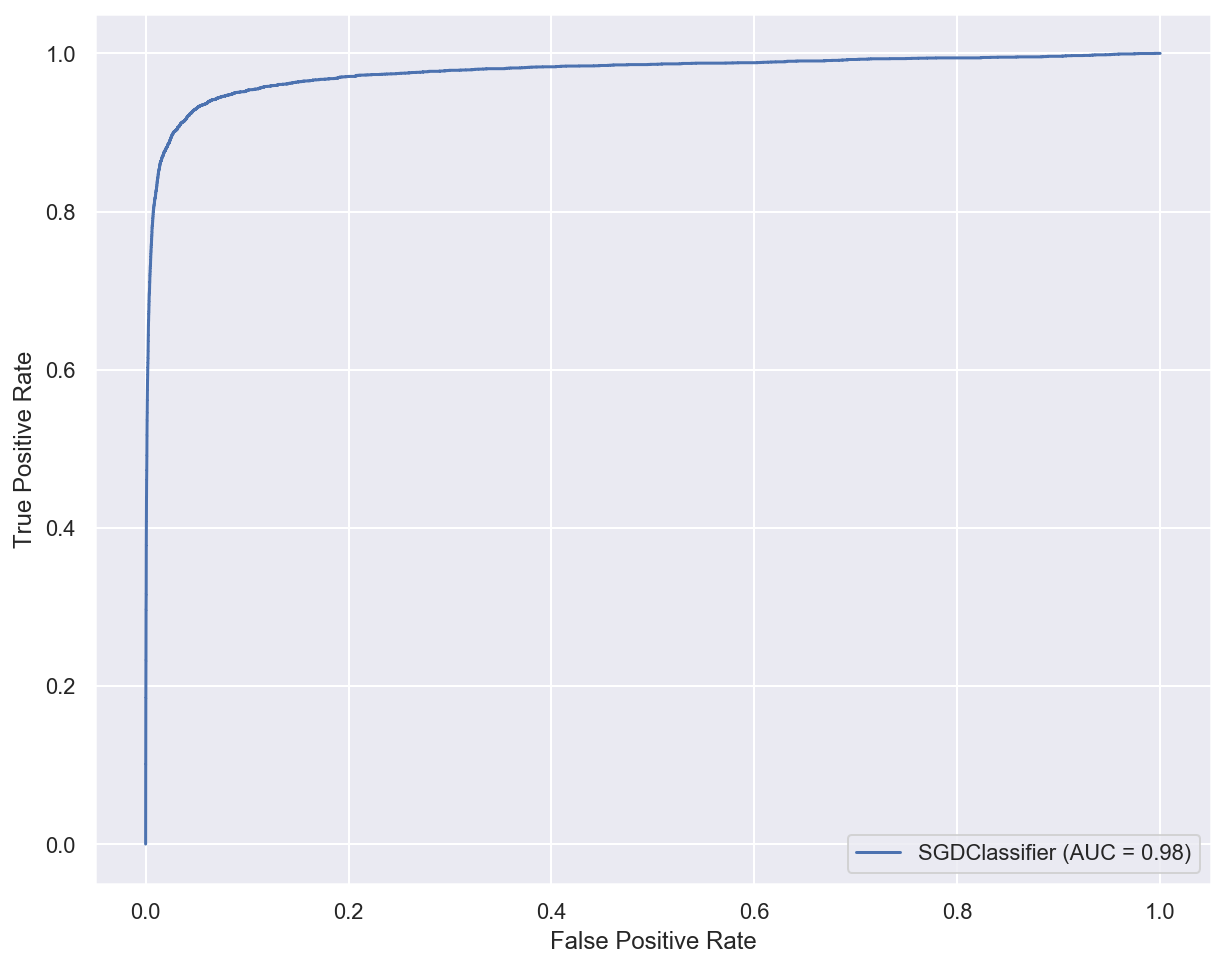

In [24]:
# Plot ROC curve for the SGD classifier
sgd_disp = plot_roc_curve(sgd_model, x_train, y_train_5)
plt.show()

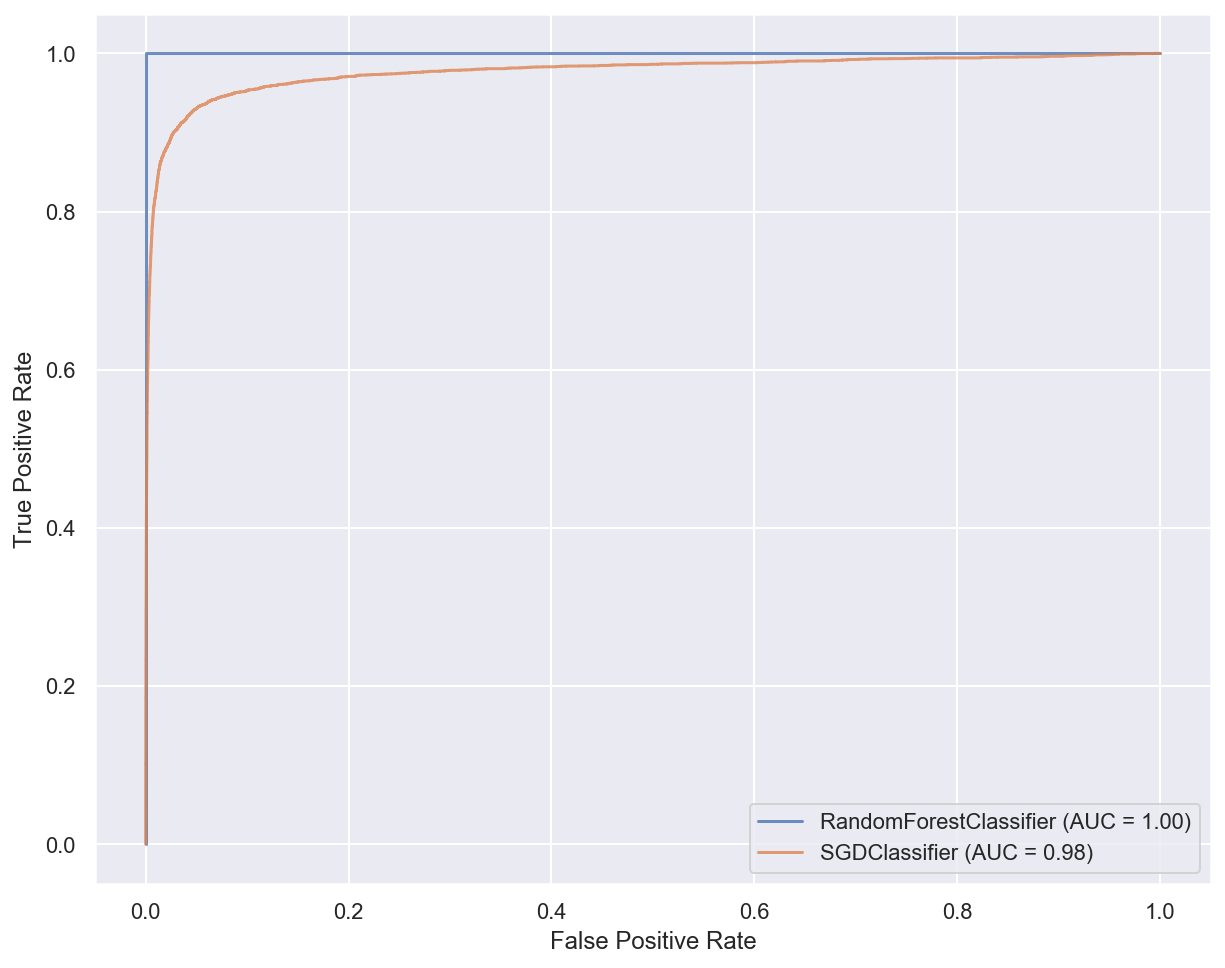

In [25]:
# Training a Random Forest classifier on same dataset
rf_model = RandomForestClassifier(n_estimators=50)
rf_model.fit(x_train, y_train_5)

# Plot ROC curves for both classifiers
ax = plt.gca()
rf_disp = plot_roc_curve(rf_model, x_train, y_train_5, ax=ax, alpha=0.8)
sgd_disp.plot(ax=ax, alpha=0.8)
plt.show()

#### Multiclass classification

In [26]:
# Using all digits in the datasets
y_train = train_labels
y_test = test_labels

# Training a SGD classifier to recognize all digits, not just 5s
multi_sgd_model = SGDClassifier(loss="log")
multi_sgd_model.fit(x_train, y_train)

# Since dataset is not class imbalanced anymore, accuracy is a reliable metric
print(f"Training accuracy: {multi_sgd_model.score(x_train, y_train):.05f}")
print(f"Test accuracy: {multi_sgd_model.score(x_test, y_test):.05f}")

Training accuracy: 0.91933
Test accuracy: 0.91540


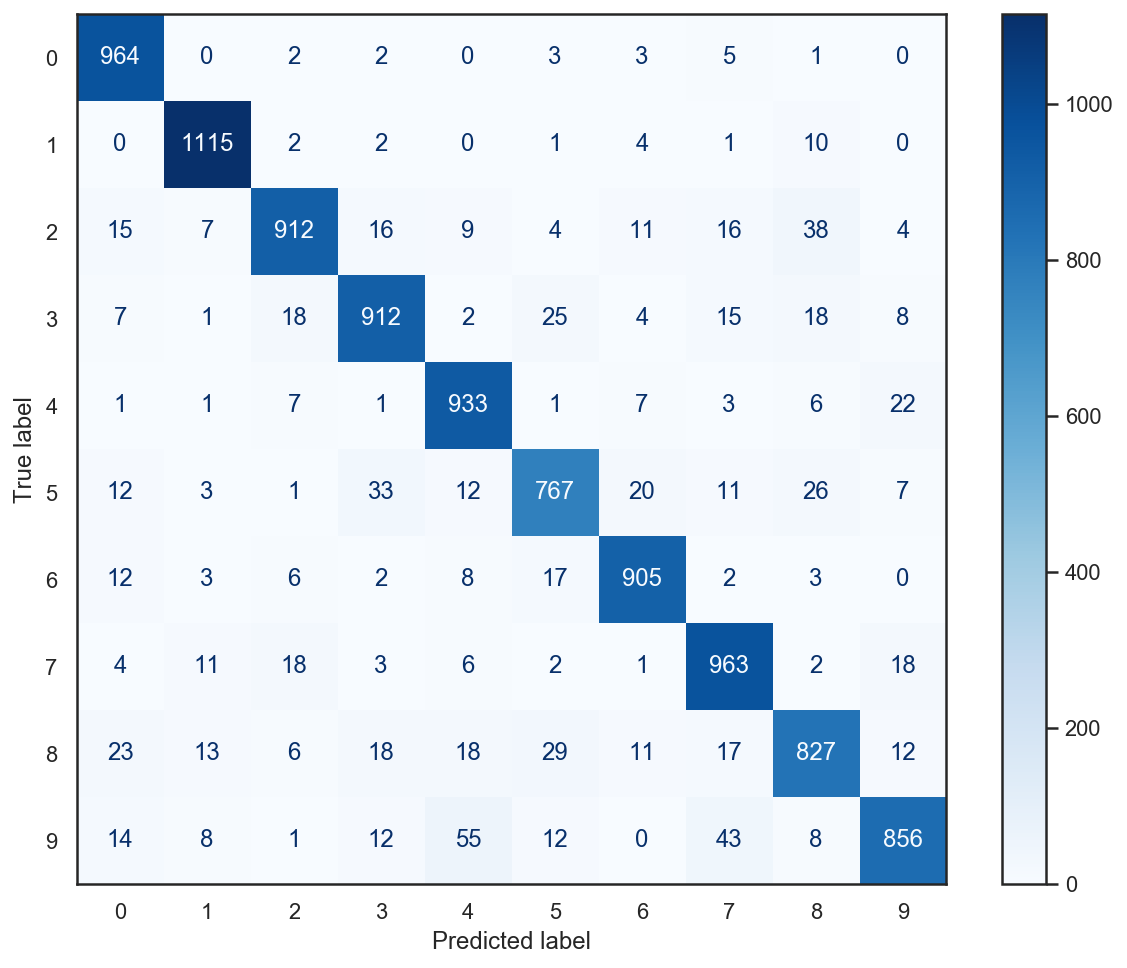

In [27]:
# Plot confusion matrix for multiclass SGD classifier on test data
plot_conf_mat(multi_sgd_model, x_test, y_test)

In [28]:
# Using scikit-learn to compute several metrics about the multiclass SGD classifier
print(classification_report(y_test, multi_sgd_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.91      0.90      0.91      1010
           4       0.89      0.95      0.92       982
           5       0.89      0.86      0.88       892
           6       0.94      0.94      0.94       958
           7       0.89      0.94      0.92      1028
           8       0.88      0.85      0.86       974
           9       0.92      0.85      0.88      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.91     10000

